# AAI-510 M3 Lab Walkthrough - Unsupervised Learning

In this lab walkthrough we will explore using the k-means algorithm to cluster data. We'll be working with the wine dataset, which is a built-in dataset in the sklearn module, more details can be found here: https://scikit-learn.org/stable/datasets/toy_dataset.html

As discussed in the lecture, often k-means is used for business interpretation. This requires a mix of quantitative and qualitative evaluation to ensure relevant business interpretation backed by the requisite technical rigor. This notebook walks through building a model, as well as evaluating different permutations of "k" when evaluating the output of k-means

In [1]:
#@title Loading the required libraries

import numpy as np # Pandas for array manipulation
import pandas as pd # Pandas for data manipulation
import seaborn as sns # Seaborn for visualizing. Note: we will also use one of the data sets
import matplotlib.pyplot as plt # Matplotlib for subplots
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # Import for feature standardization
from sklearn.metrics import silhouette_samples, silhouette_score # For kmeans evaluation
from sklearn.datasets import load_wine # Used to pull in wine data

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 500)

### Data Processing

In [2]:
# Load in wine dataset

wine = load_wine(return_X_y=True, as_frame=True)
wine_df = wine[0]
wine_target = wine[1]

print(f'distribution of target variable: {wine_target.value_counts()}')
# Look at raw attributes
wine_df.head()

distribution of target variable: 1    71
0    59
2    48
Name: target, dtype: int64


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.60,127.00,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.00
1,13.20,1.78,2.14,11.20,100.00,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.00
2,13.16,2.36,2.67,18.60,101.00,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.00
3,14.37,1.95,2.50,16.80,113.00,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.00
4,13.24,2.59,2.87,21.00,118.00,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.00


It looks like all features are continuous values but on different scales. We'll need to scale data in order to prevent larger magnitude columns from taking over the model. Let's take a look at the raw distribution of each feature, and then grab the means of all features

In [3]:
means = []
for col in wine_df.columns:
    print(f'Producing stats for column: {col}')
    print(wine_df[col].describe([0.1, 0.25, 0.5, 0.75, 0.9]))
    means.append([col,wine_df[col].describe()['mean']])

Producing stats for column: alcohol
count   178.00
mean     13.00
std       0.81
min      11.03
10%      11.93
25%      12.36
50%      13.05
75%      13.68
90%      14.10
max      14.83
Name: alcohol, dtype: float64
Producing stats for column: malic_acid
count   178.00
mean      2.34
std       1.12
min       0.74
10%       1.25
25%       1.60
50%       1.87
75%       3.08
90%       3.98
max       5.80
Name: malic_acid, dtype: float64
Producing stats for column: ash
count   178.00
mean      2.37
std       0.27
min       1.36
10%       2.00
25%       2.21
50%       2.36
75%       2.56
90%       2.70
max       3.23
Name: ash, dtype: float64
Producing stats for column: alcalinity_of_ash
count   178.00
mean     19.49
std       3.34
min      10.60
10%      16.00
25%      17.20
50%      19.50
75%      21.50
90%      24.00
max      30.00
Name: alcalinity_of_ash, dtype: float64
Producing stats for column: magnesium
count   178.00
mean     99.74
std      14.28
min      70.00
10%      85.00
25%  

Mean is a crude way of evaluating this, but clearly there's a distinct different in mean across the different variables. This helps directly motivate the need to scale data to accommodate for the k-means algorithm

In [4]:
pd.DataFrame(means, columns = ['column', 'mean'])

,column,mean
0,alcohol,13.00
1,malic_acid,2.34
2,ash,2.37
3,alcalinity_of_ash,19.49
4,magnesium,99.74
5,total_phenols,2.30
6,flavanoids,2.03
7,nonflavanoid_phenols,0.36
8,proanthocyanins,1.59
9,color_intensity,5.06


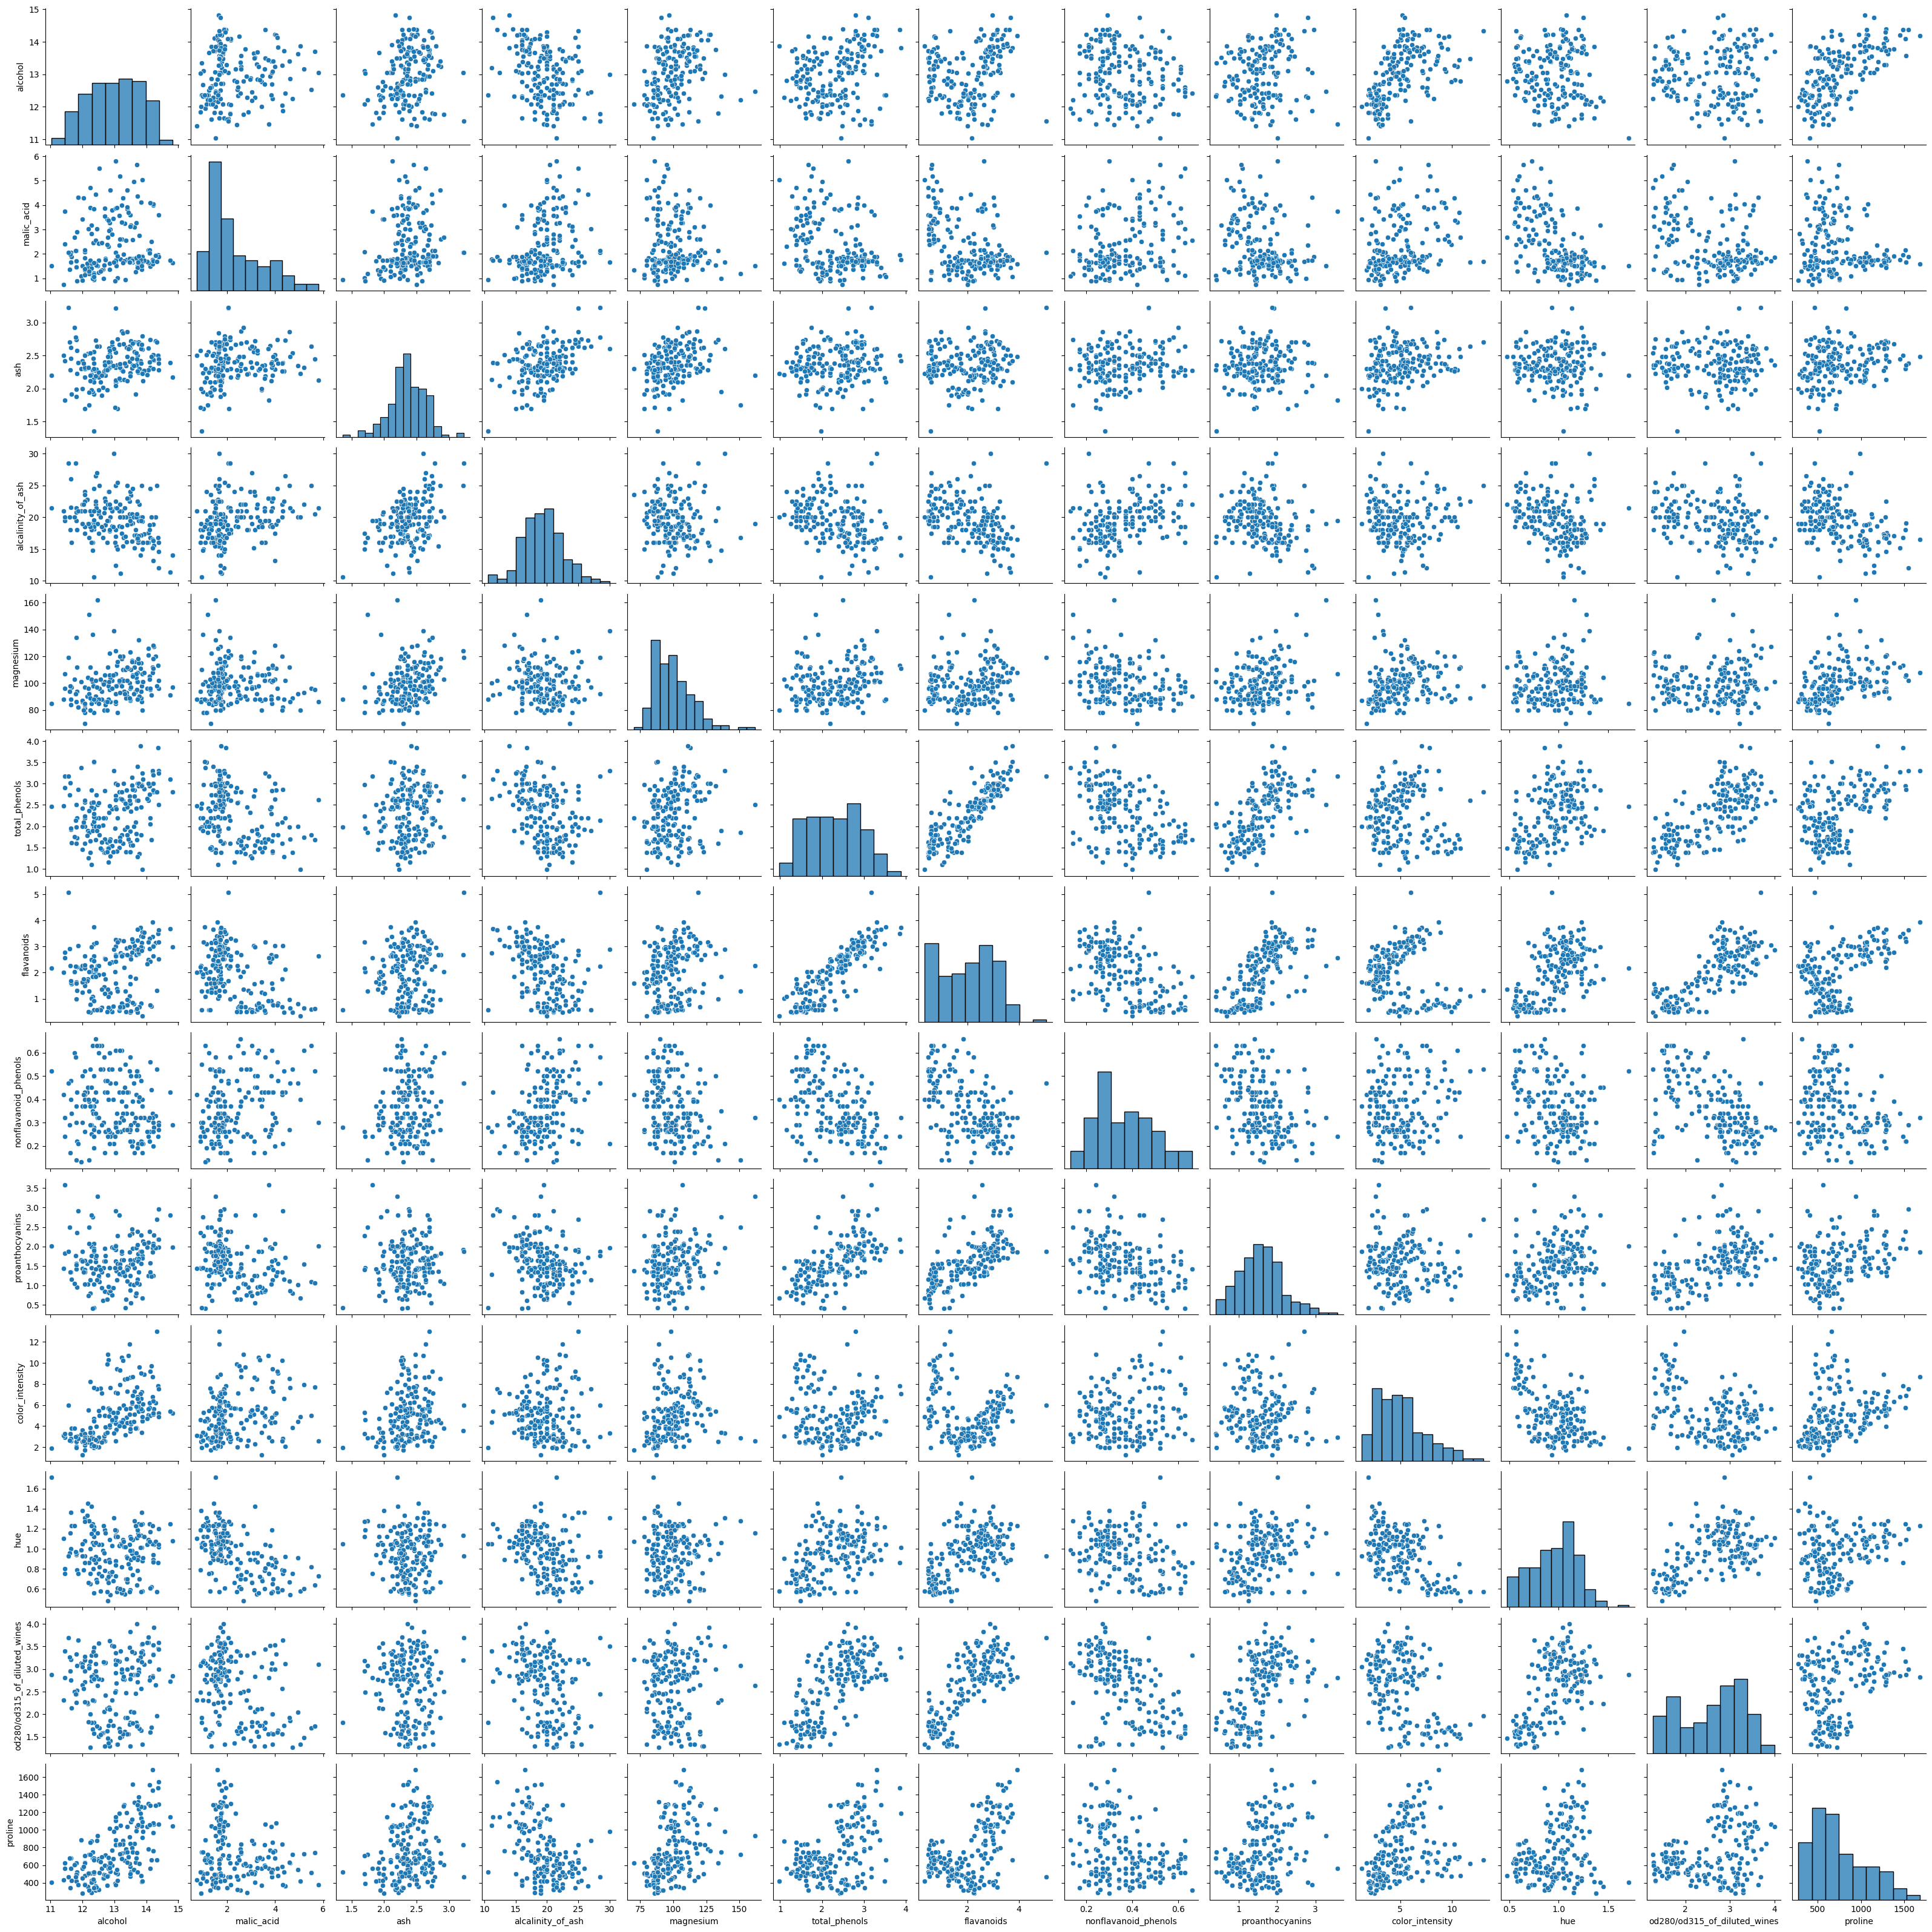

In [5]:
# Plot the scaled data

sns.pairplot(wine_df) # Plot each variable against all other variables
plt.show()

In [6]:
# Let's scale the data

scaler = StandardScaler()
scaled_data = scaler.fit_transform(wine_df)
scaled_wine_df = pd.DataFrame(scaled_data, columns = wine_df.columns)

In [7]:
# Now let's evaluate the scaled data in the same fashion

scaled_means = []
for col in scaled_wine_df.columns:
    print(f'Producing stats for column: {col}')
    print(scaled_wine_df[col].describe([0.1, 0.25, 0.5, 0.75, 0.9]))
    scaled_means.append([col,scaled_wine_df[col].describe()['mean']])

Producing stats for column: alcohol
count   178.00
mean     -0.00
std       1.00
min      -2.43
10%      -1.32
25%      -0.79
50%       0.06
75%       0.84
90%       1.36
max       2.26
Name: alcohol, dtype: float64
Producing stats for column: malic_acid
count   178.00
mean     -0.00
std       1.00
min      -1.43
10%      -0.98
25%      -0.66
50%      -0.42
75%       0.67
90%       1.48
max       3.11
Name: malic_acid, dtype: float64
Producing stats for column: ash
count   178.00
mean     -0.00
std       1.00
min      -3.68
10%      -1.34
25%      -0.57
50%      -0.02
75%       0.70
90%       1.22
max       3.16
Name: ash, dtype: float64
Producing stats for column: alcalinity_of_ash
count   178.00
mean     -0.00
std       1.00
min      -2.67
10%      -1.05
25%      -0.69
50%       0.00
75%       0.60
90%       1.35
max       3.15
Name: alcalinity_of_ash, dtype: float64
Producing stats for column: magnesium
count   178.00
mean     -0.00
std       1.00
min      -2.09
10%      -1.04
25%  

In [8]:
pd.DataFrame(scaled_means, columns = ['column', 'mean'])

,column,mean
0,alcohol,-0.00
1,malic_acid,-0.00
2,ash,-0.00
3,alcalinity_of_ash,-0.00
4,magnesium,-0.00
5,total_phenols,0.00
6,flavanoids,-0.00
7,nonflavanoid_phenols,0.00
8,proanthocyanins,-0.00
9,color_intensity,0.00


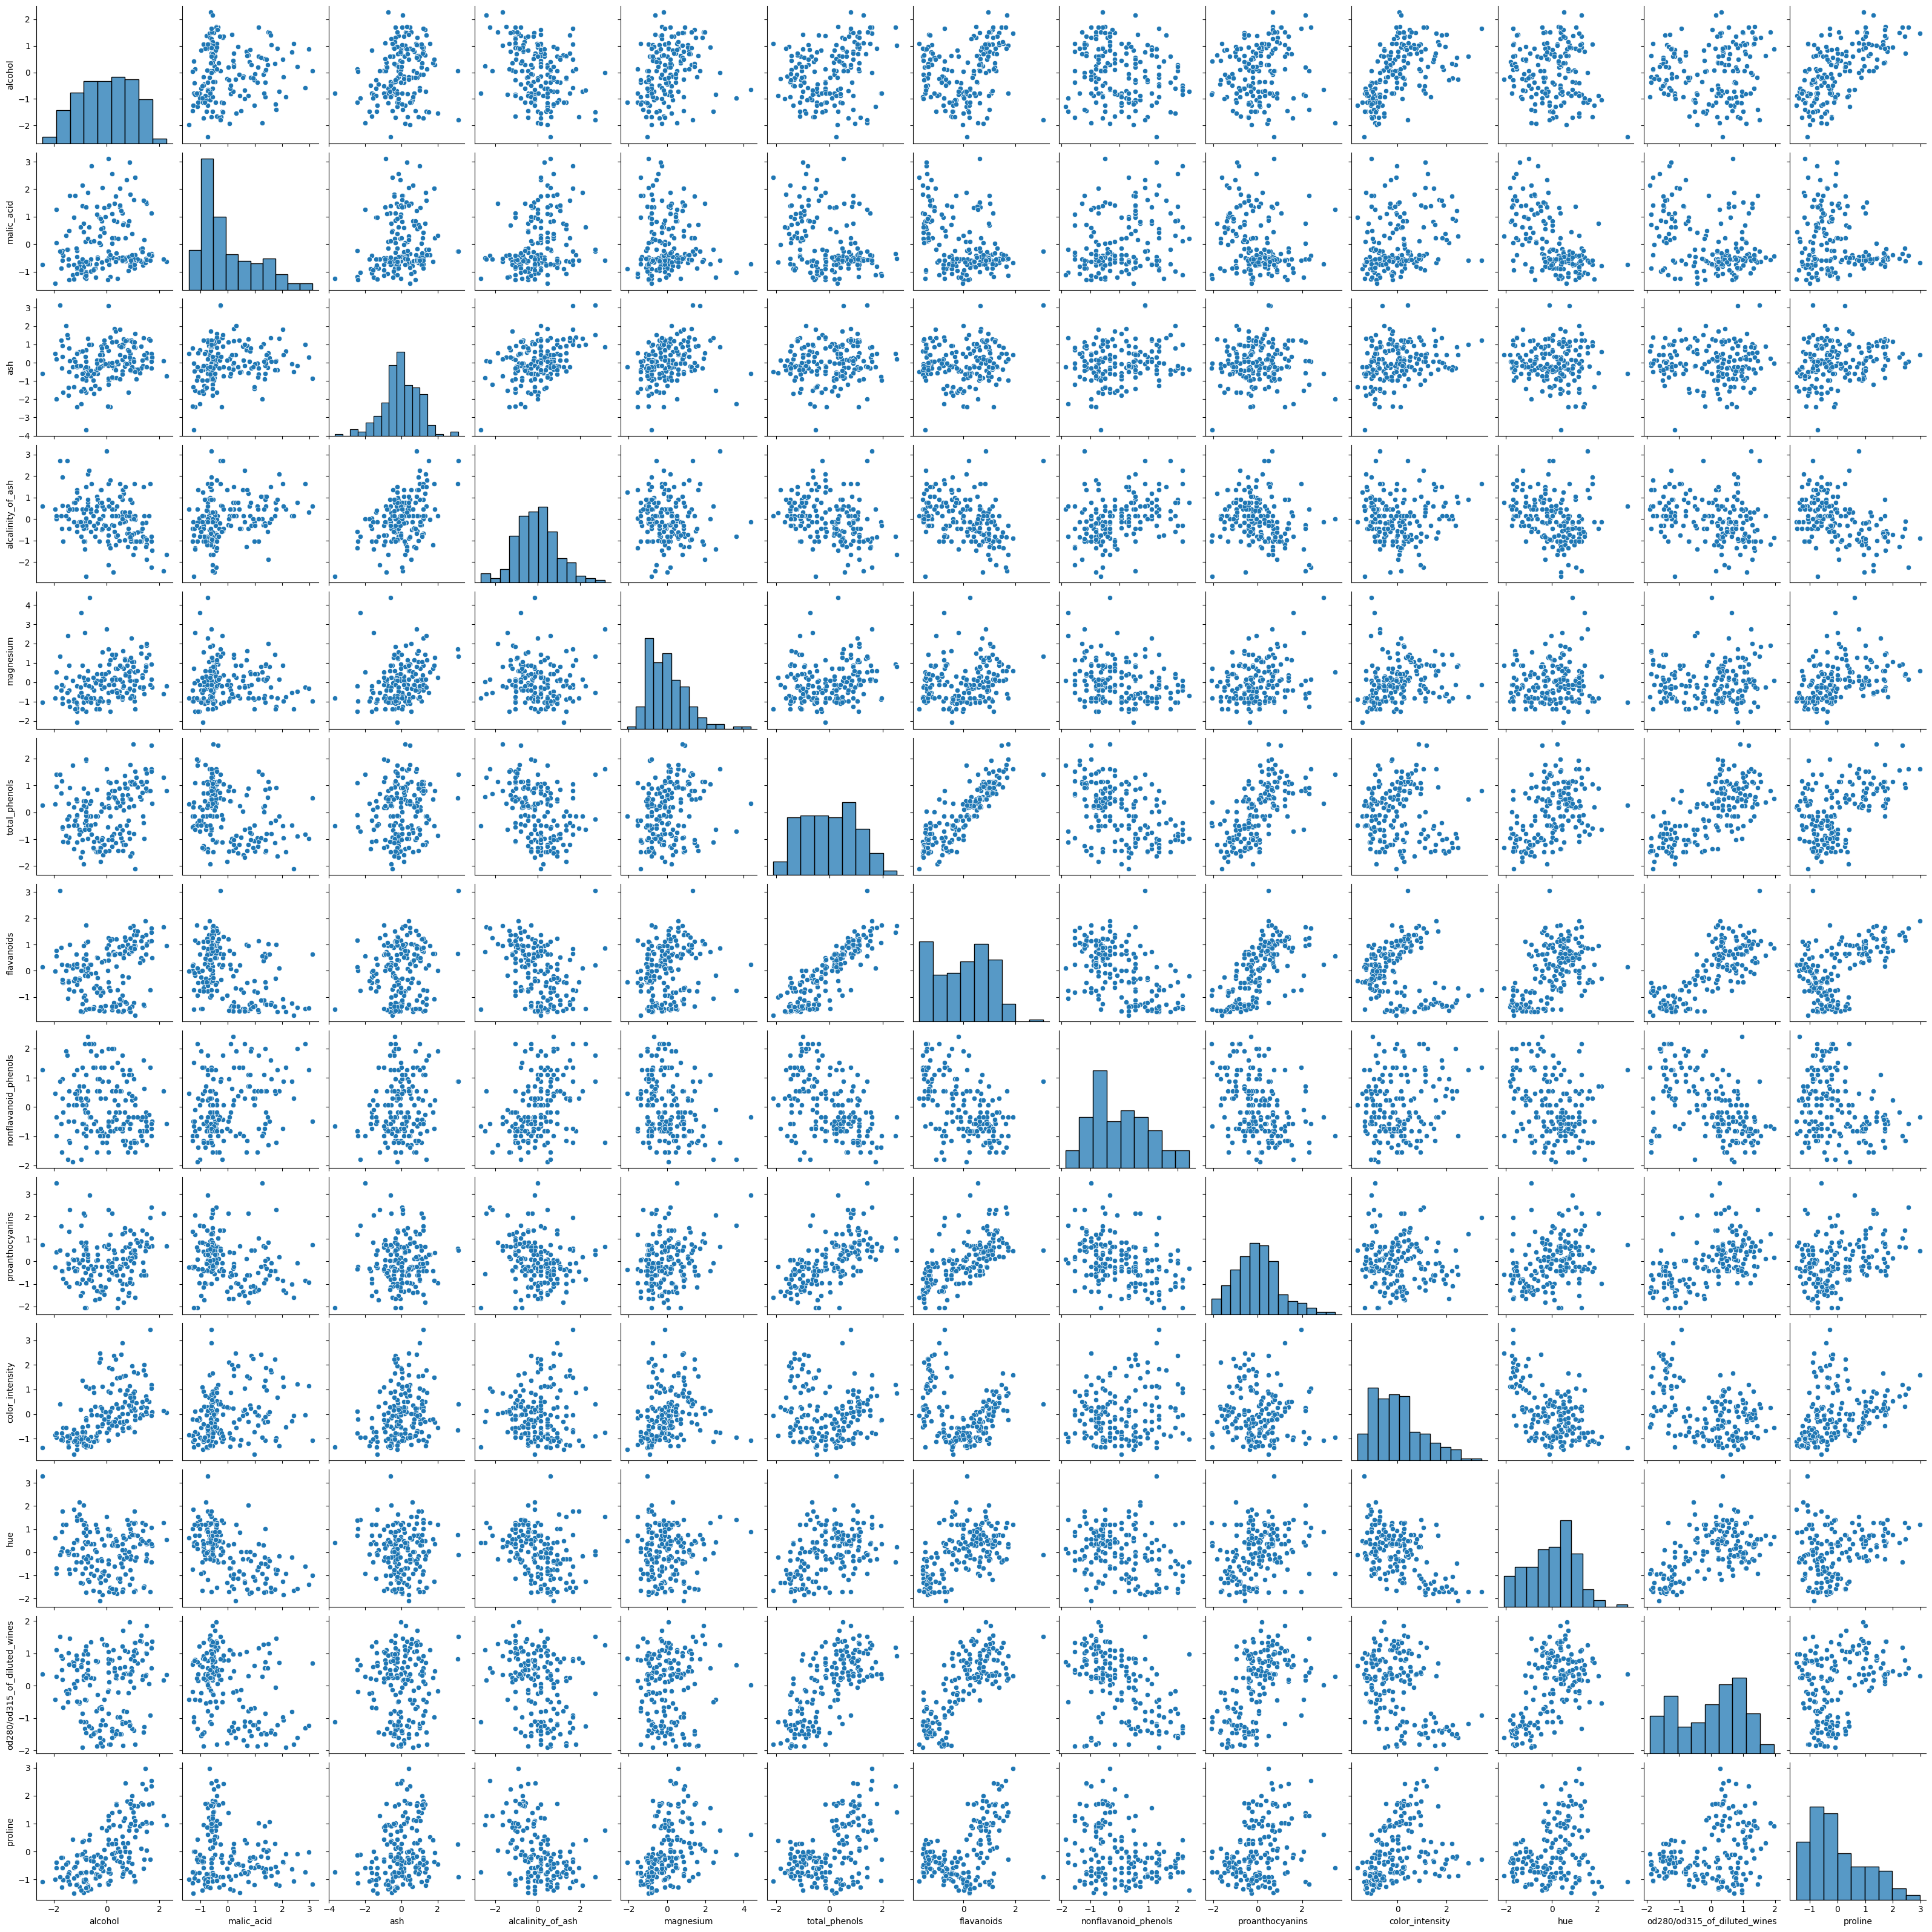

In [9]:
# Plot the scaled data
# You can see the variable relationships are maintained but the magnitude of the variables are different relative to the raw data

sns.pairplot(scaled_wine_df) # Plot each variable against all other variables
plt.show()

## K-Means Clustering

We'll run multiple variations of K-means with different variations of k-means, from 2-6. Then we'll evaluate the output - we'll evaluate by joining the raw data back with the cluster assignments, including the target variable available in the dataset, then looking at how the clusters map to the raw data.

We're not experts in this data, but we'll try to make inferences to determine what makes more sense from a business context, and also evaluate the clusters quantiatively to determine the "right" number of clusters. In practice this is an iterative process that combines subject matter expertise with quantitative support!

On the quantitative side we'll look at the Silhouette scores, and generate an "Elbow Curve" to try and find the right quantitative version of k. The Silhouette score ranges from -1 to 1, where a high score means an observation is well matched to its own cluster. The average score across clusters shows roughly how well each data point is represented by its own cluster relative to others. The elbow curve shows the distortion (or sum of squared distances from each point to its cluster center), the distortion decreases as the number of clusters increases, but there's a point (the "elbow") where diminshing returns are reached, and that point is determined to be the "optimal" k.

In this data we also have the benefit of having an explicit target variable to compare the clusters against - this won't always be true in practice. But since it's available here, it's a helpful way to frame the evaluation. Additionally, in practical scenarios we are not restricted to *just* the data used in the clustering analysis to help evaluate the clusters. Categorical features (that have not be vectorized into embeddings) are not conducive to be included in a k-means analysis, but *are* useful to include to summarize the different clusters afterwards to better understand their composition. In this example, we don't include the target variable in the clustering exercise, but we do use it to help interpret the clusters generated.

Additionally as an experiment, use the raw, untransformed features and see how it compares to the clusters generated from the transformed features. Does it seem like certain features (notably features with larger magnitude and more variance) are dominating the cluster assignments?

In [10]:
def kmeans_execution(df, num_clust):
    # Create models & store labels for different number of clusters
    kmn = KMeans(n_clusters = num_clust, n_init='auto', random_state = 0) # Create KMeans object 
    kmn.fit(df) # Apply to the data
    kmn_lbl = kmn.labels_ # Capture K-Means labels
    kmn_distortion = kmn.inertia_ # Used for elbow method
    return kmn, kmn_lbl, kmn_distortion

kmn_2_mod, kmn_2_labels, kmn_2_dist = kmeans_execution(scaled_wine_df, 2)
silhouette_2 = silhouette_score(scaled_wine_df, kmn_2_labels)
print(f'k=2 silhouette average score: {silhouette_2}')
kmn_3_mod, kmn_3_labels, kmn_3_dist = kmeans_execution(scaled_wine_df, 3)
silhouette_3 = silhouette_score(scaled_wine_df, kmn_3_labels)
print(f'k=3 silhouette average score: {silhouette_3}')
kmn_4_mod, kmn_4_labels, kmn_4_dist = kmeans_execution(scaled_wine_df, 4)
silhouette_4 = silhouette_score(scaled_wine_df, kmn_4_labels)
print(f'k=4 silhouette average score: {silhouette_4}')
kmn_5_mod, kmn_5_labels, kmn_5_dist = kmeans_execution(scaled_wine_df, 5)
silhouette_5 = silhouette_score(scaled_wine_df, kmn_5_labels)
print(f'k=5 silhouette average score: {silhouette_5}')
kmn_6_mod, kmn_6_labels, kmn_6_dist = kmeans_execution(scaled_wine_df, 6)
silhouette_6 = silhouette_score(scaled_wine_df, kmn_6_labels)
print(f'k=6 silhouette average score: {silhouette_6}')

k=2 silhouette average score: 0.26831340971052126
k=3 silhouette average score: 0.2844212860533542
k=4 silhouette average score: 0.24503693354956807
k=5 silhouette average score: 0.23187479572412723
k=6 silhouette average score: 0.18898563558994827


Text(0.5, 1.0, 'Elbow curve')

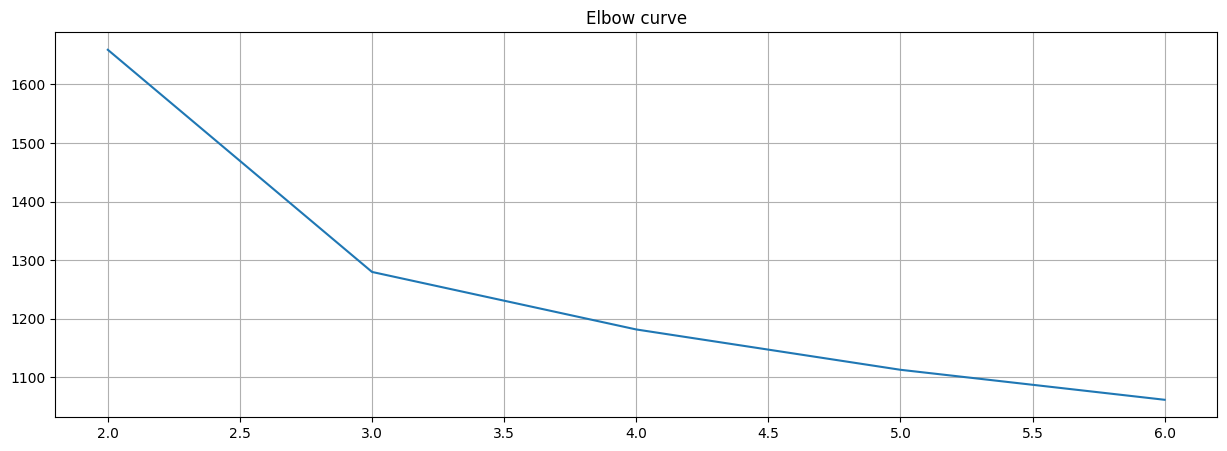

In [11]:
# Elbow Plot - seems like clear "elbow" at k=3

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 7), [kmn_2_dist, kmn_3_dist, kmn_4_dist, kmn_5_dist, kmn_6_dist])
plt.grid(True)
plt.title('Elbow curve')

In [12]:
# Create evaluation dataset

wine_eval_df = wine_df.copy()
wine_eval_df['target'] = wine_target
wine_eval_df['kmn_3_label'] = kmn_3_labels
wine_eval_df['kmn_4_label'] = kmn_4_labels
wine_eval_df['kmn_5_label'] = kmn_5_labels
wine_eval_df['kmn_6_label'] = kmn_6_labels

In [13]:
# Create function to group by labels and look at output

def group_by_cluster(df, col_val):
    exclude_columns = ['target', 'kmn_3_label', 'kmn_4_label', 'kmn_5_label', 'kmn_6_label']
    cont_cols = [col for col in df.columns if col not in exclude_columns]
    # Get summary stats grouped by cluster
    df_group = df.groupby(col_val)[cont_cols].agg(['mean', 'median', 'std']).reset_index()
    # See distribution of target variable grouped by cluster
    value_counts = df.groupby(col_val)['target'].agg(lambda x:x.value_counts().to_dict())
    return df_group, value_counts

In [14]:
# Can execute across different values of k to determine differences in clusters
summary_stats, target_groups = group_by_cluster(wine_eval_df, kmn_3_labels)
summary_stats

index alcohol             malic_acid              ash              \
           mean median  std       mean median  std mean median  std   
0     0   13.13  13.11 0.52       3.31   3.27 1.09 2.42   2.38 0.20   
1     1   12.24  12.23 0.54       1.93   1.62 1.01 2.26   2.26 0.32   
2     2   13.67  13.73 0.55       1.97   1.75 0.69 2.43   2.43 0.25   

  alcalinity_of_ash             magnesium              total_phenols         \
               mean median  std      mean median   std          mean median   
0             21.24  21.00 2.41     98.67  97.00 11.07          1.68   1.65   
1             20.33  20.20 3.12     91.56  88.00 10.77          2.27   2.20   
2             17.23  16.80 2.98    108.92 106.00 14.49          2.81   2.80   

       flavanoids             nonflavanoid_phenols              \
   std       mean median  std                 mean median  std   
0 0.35       0.82   0.70 0.32                 0.45   0.47 0.12   
1 0.54       2.11   2.04 0.71                 0.36   0.37 0.12   
2 0.38       2.92   2.94 0.47                 0.29   0.29 0.07   

  proanthocyanins             color_intensity              hue              \
             mean median  std            mean median  std mean median  std   
0            1.15   1.10 0.41            7.23   7.30 2.35 0.69   0.67 0.12   
1            1.60   1.56 0.55            3.02   2.90 0.88 1.06   1.04 0.20   
2            1.95   1.95 0.45            5.37   5.25 1.35 1.07   1.07 0.12   

  od280/od315_of_diluted_wines             proline                 
                          mean median  std    mean  median    std  
0                         1.70   1.68 0.27  619.06  620.00 120.72  
1                         2.82   2.85 0.47  502.47  484.00 138.09  
2                         3.14   3.10 0.37 1098.68 1065.00 226.08

In [15]:
# Look at distribution of target variable in different clusters created

target_groups

0    {2: 48, 1: 3}
1          {1: 64}
2    {0: 59, 1: 4}
Name: target, dtype: object

# Write up of business impact and interpretation

It appears that a k=3 number of clusters provides the most business value and is supported by quantitative evaluation metrics leveraged as well. 

On the quantitative side, k=3 produces the highest silhouette score, indicating the most uniformity within each cluster, and also is the clear "elbow" in the elbow curve chart shown above. 

On the business side, we have the benefit of having a target variable in this data, and k=3 also seems like a logical number of groupings based on subjective interpretation of the data. While the target variable was not included in the clustering exercise, there are 3 different classes in the target variable, and the clusters generated split the data in a way that very much resembles the target classes. Cluster 0  has all examples of class 2, the cluster 2 has all examples of class 0, and the first cluster has 64 of the 71 available examples of class 1.

Within the features that represent the data, cluster 0 appears to have notably higher malic acid, aclalinity of ash, and color intensity, with lower od280, hue, proathnocyanis, flavanoids & total phenosis than the other clusters, indicating that these combinations must distinguish the different wine types.

An extension of this analysis could be to have ratings associated with each wine, where the combination of these quantitative features could be used to predict the quality of wine, controlling for the wine type (or the target class in this data).